# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [2]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [3]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs
        
if not os.path.exists('tables'):
    !mkdir tables

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig, write_table

## Improving Reading Ability

In this notebook I'll explore data from a [Ph.D. dissertation in educational psychology](https://docs.lib.purdue.edu/dissertations/AAI8807671/) written in 1987, used as an example in a [statistics textbook](https://books.google.com/books/about/Introduction_to_the_practice_of_statisti.html?id=pGBNhajABlUC) from 1989, and made popular on [DASL](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html), a web page that publishes data stories.  

Here's the description from DASL:

> An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

The [dataset is available here](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html); I have put it in a CSV file, which we can download like this:

In [5]:
import os

if not os.path.exists('drp_scores.csv'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv

I'll use Pandas to load the data into a DataFrame.

In [6]:
import pandas as pd

df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


I'll use `groupby` to separate the data for the `Treated` and `Control` groups:

In [7]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

Here are CDFs of the scores for the two groups and summary statistics.

Control 23 41.52173913043478 17.148733229699484
Treated 21 51.476190476190474 11.00735684721381


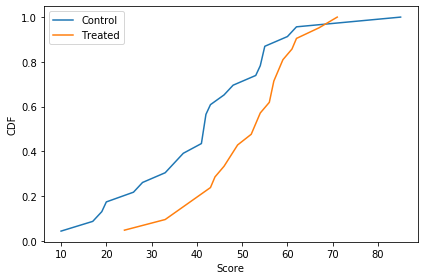

In [8]:
for name, response in responses.items():
    print(name, len(response), response.mean(), response.std())
    cdf = Cdf.from_seq(response)
    cdf.plot(label=name)
    
decorate(xlabel='Score', ylabel='CDF')

The distribution of scores is not exactly normal for either group, but it is close enough that the normal model is a reasonable choice.

So I'll assume that in the entire population of students (not just the ones in the experiment), the distribution of scores is well modeled by a normal distribution with unknown mean and standard deviation.
I'll use `mu` and `sigma` to denote these unknown population parameters.

And we'll do a Bayesian update to estimate what they are.

## Estimating parameters

As always, we need a prior distribution for the parameters.  
Since there are two parameters, it will be a joint distribution.  
I'll construct it by choosing marginal distributions for each parameter and computing their outer product.

As a simple starting place, I'll assume that the prior distributions for `mu` and `sigma` are uniform.

In [9]:
mus = np.linspace(20, 80, 101)
prior_mu = Pmf(1, mus, name='mean')

In [10]:
sigmas = np.linspace(5, 30, 101)
prior_sigma = Pmf(1, sigmas, name='std')

In [11]:
from utils import outer_product

prior = outer_product(prior_mu, prior_sigma)

In [12]:
data = responses['Control']
data.shape

(23,)

Now, we would like to know the probability of each score in the dataset for each hypothetical pair of values, `mu` and `sigma`.
I'll do that by making a 3-dimensional grid with values of `sigma` on the first axis, values of `mu` on the second axis, and the scores from the dataset on the third axis.

In [13]:
sigmas, mus, data_mesh = np.meshgrid(prior.columns, prior.index, data)
sigmas.shape

(101, 101, 23)

Now we can use `norm.pdf` to compute the probability density of each score for each hypothetical pair of parameters.

In [14]:
from scipy.stats import norm

densities = norm.pdf(data_mesh, sigmas, mus)
densities.shape

(101, 101, 23)

The result is a 3-D array.  To compute likelihoods, I'll compute the product of these densities along the third axis, that is `axis=2`:

In [15]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

The result is a 2-D array that contains the likelihood of the entire dataset for each hypothetical pair of parameters.

We can use this array as part of a Bayesian update, as in this function:

In [16]:
from utils import normalize

def update_norm(prior, data):
    """Update the prior based on data.
    
    prior: joint distribution of mu and sigma
    data: sequence of observations
    """
    X, Y, Z = np.meshgrid(prior.columns, prior.index, data)
    likelihood = norm.pdf(Z, Y, X).prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

Here are the updates for the control and treatment groups:

In [17]:
data = responses['Control']
posterior_control = update_norm(prior, data)

In [18]:
data = responses['Treated']
posterior_treated = update_norm(prior, data)

And here's what they look like:

In [19]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel='Standard deviation', ylabel='Mean')
    return cs

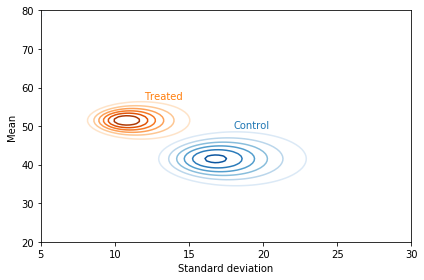

In [20]:
plot_contour(posterior_control, cmap='Blues')
plt.text(18, 49.5, 'Control', color='C0')

cs = plot_contour(posterior_treated, cmap='Oranges')
plt.text(12, 57, 'Treated', color='C1');

Along the vertical axis, it looks like the mean score for the treated group is higher.
Along the horizontal axis, it looks like the standard deviation for the control group is higher.

If we think the treatment causes these differences, the data suggest that the treatment increase the mean score and decreases their spread.
We can see these differences more clearly by looking at the marginal distributions for `mu` and `sigma`.

## Posterior marginal distributions

I'll use `marginal`, which we saw in Chapter 9, to extract the posterior marginal distributions for the population mean.

In [21]:
from utils import marginal

pmf_mean_control = marginal(posterior_control, 1)
pmf_mean_treated = marginal(posterior_treated, 1)

Here's what they look like:

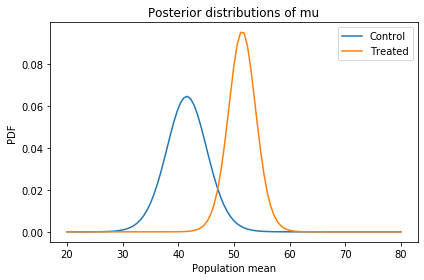

In [22]:
pmf_mean_control.plot(label='Control')
pmf_mean_treated.plot(label='Treated')

decorate(xlabel='Population mean', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

It looks like we are pretty sure that the population mean in the treated group is higher.
We can use `prob_gt` to compute the probability of superiority:

In [23]:
Pmf.prob_gt(pmf_mean_treated, pmf_mean_control)

0.9804790251873259

There is a 98% chance that the mean in the treated group is higher.

We can use `sub_dist` to compute the distribution of the difference.

In [96]:
diff = Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)

Two things to be careful about when you use methods like `sub_dist`: 

The first is that the result usually contains more elements than the original `Pmf`.  
In this example, the original distributions have the same quantities, so the size increase is moderate.

In [99]:
len(pmf_mean_treated), len(pmf_mean_control), len(diff)

(101, 101, 879)

In the worst case, the size of the result can be the product of the sizes of the originals.

The other thing to be aware of is that plotting a `Pmf` does not always work well.
In this example, if we plot the distribution of differences, the result is pretty noisy.

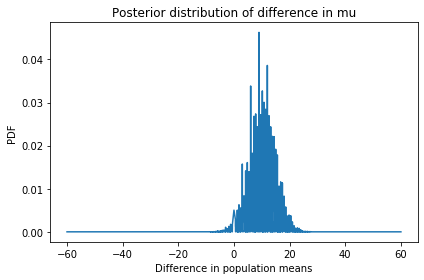

In [100]:
diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

There are two ways to work around that limitation.  One is to plot the CDF, which smooths out the noise:

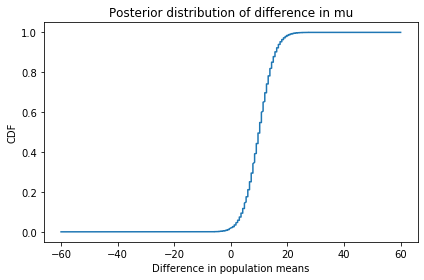

In [102]:
diff.make_cdf().plot()

decorate(xlabel='Difference in population means', 
         ylabel='CDF', 
         title='Posterior distribution of difference in mu')

The other option is to use kernel density estimation (KDE) to make a smooth approximation of the PDF on an equally-spaced grid.

In [103]:
from scipy.stats import gaussian_kde

def make_kde(pmf, n=101):
    """
    """
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

Here's what it looks like.

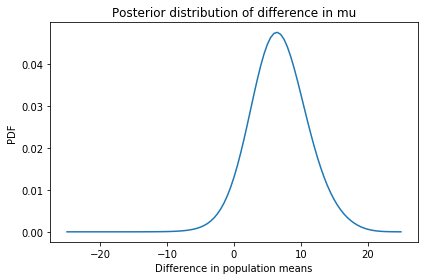

In [93]:
make_kde(diff).plot()

decorate(xlabel='Difference in population means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

The mean is almost 10 points, which is substantial.

In [27]:
diff.mean()

9.954413088940848

Finally, we can use `credible_interval` to compute a 90% credible interval.

In [28]:
diff.credible_interval(0.9)

array([ 2.4, 17.4])

Based on the data, we are pretty sure the treatment improves test scores by 2 to 17 points.

## Using summary statistics

In this example the dataset is not very big, so it doesn't take too long to compute the probability of every score under every hypothesis.
But the result is a 3-D array; for larger datasets, it might be too big to compute practically.

Also, with larger datasets the likelihoods can get very small, sometimes so small that we can't compute them with normal floating-point arithmetic.
That's because we are computing the probability of a particular dataset.  The number of possible datasets is astronomically big, so the probability of any of them is very small.

An alternative is to compute a summary of the dataset and compute the likelihood of the summary.
For example, if we compute the sample mean of the data and the sample standard deviation, we could compute the likelihood of those summary statistics under each hypothesis.

As an example, suppose we know that the population mean is 40 and the standard deviation is 17.
We can make a `norm` object that represents a normal distribution with these parameters:

In [29]:
mu = 40
sigma = 17
dist = norm(mu, sigma)

Now suppose we draw 1000 samples from this distribution with sample size `n=20`.
I'll use `rvs`, which generates a random sample, to simulate this experiment.

In [30]:
n = 20
samples = dist.rvs((n, 1000))

The result is an array with 1000 rows, each containing a sample with 20 columns.

If we compute the mean of each row, the result is an array that contains 1000 sample means; that is, each value is the mean of a sample with `n=20`.

In [31]:
sample_means = samples.mean(axis=0)
sample_means.shape

(1000,)

Now, we would like to know what the distribution of these sample means is.
Using the properties of the normal distribution, [we can show](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables) that their distribution is normal with mean $\mu$ and standard deviation $\sigma/\sqrt{n}$:

In [32]:
dist_m = norm(mu, sigma/np.sqrt(n))

`dist_m` represents the "sampling distribution of the mean".  The following figure shows this theoretical distribution along with the empirical distribution of the values in `sample_means`.

In [33]:
low, high = sample_means.min(), sample_means.max()
qs = np.linspace(low, high, 101)
ps = dist_m.cdf(qs)
cdf_m = Cdf(ps, qs)

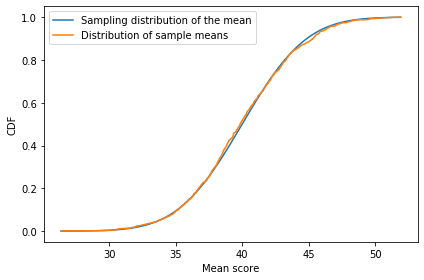

In [34]:
cdf_m.plot(label='Sampling distribution of the mean')
Cdf.from_seq(sample_means).plot(label='Distribution of sample means')

decorate(xlabel='Mean score',
         ylabel='CDF')

The random sample means we generated follow the theoretical distribution closely, as expected.

We can also compute standard deviations for each row in `samples`.

In [35]:
sample_stds = samples.std(axis=0)
sample_stds.shape

(1000,)

The result is an array of sample standard deviations.
We might wonder what the distribution of these values is.
The [derivation is not as easy](https://en.wikipedia.org/wiki/Normal_distribution#Sample_variance), but if we transform the sample standard deviations like this:

$t = n s^2 / \sigma^2$

where $n$ is the sample size, $s$ is the sample standard deviation, and $\sigma$ is the population standard deviation, the transformed values follow a [chi-square distribution](https://en.wikipedia.org/wiki/Chi-square_distribution) with $n-1$ degrees of freedom.

In [36]:
transformed = n * sample_stds**2 / sigma**2

To see whether that's true, I'll create a `chi2` object that represents a chi-square distribution.

In [37]:
from scipy.stats import chi2

dist_s = chi2(n-1)

And we can compare the theoretical distribution to the empirical distribution of the sample standard deviations.

In [38]:
low, high = transformed.min(), transformed.max()
qs = np.linspace(low, high, 101)
ps = dist_s.cdf(qs)
cdf_s = Cdf(ps, qs)

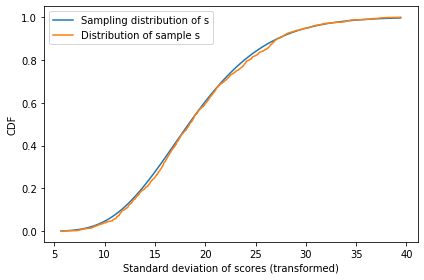

In [39]:
cdf_s.plot(label='Sampling distribution of s')
Cdf.from_seq(transformed).plot(label='Distribution of sample s')

decorate(xlabel='Standard deviation of scores (transformed)',
         ylabel='CDF')

The sample mean and sample standard deviation are independent, as we can see by making a contour plot.

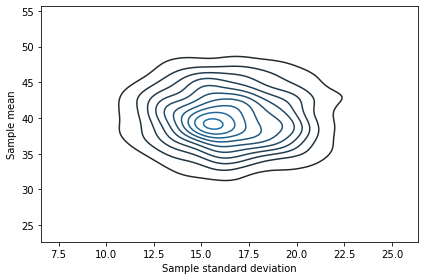

In [40]:
import seaborn as sns

sns.kdeplot(sample_stds, sample_means)

decorate(xlabel='Sample standard deviation', ylabel='Sample mean')

## Update with summary statistics

Now we're ready to do an update.
I'll compute summary statistics for the two groups.

In [41]:
summary = {}

for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()
    
summary

{'Control': (23, 41.52173913043478, 17.148733229699484),
 'Treated': (21, 51.476190476190474, 11.00735684721381)}

The result is a dictionary that maps from group name to a tuple that contains the sample size, `n`, the sample mean, `m`, and the sample standard deviation `s`, for each group.

I'll demonstrate the update with the summary statistics from the control group.

In [42]:
n, m, s = summary['Control']

I'll make a mesh with hypothetical values of `mu` on the vertical axis and values of `sigma` on the horizontal axis.

In [43]:
sigmas, mus = np.meshgrid(prior.columns, prior.index)
sigmas.shape

(101, 101)

Now we can compute the likelihood of seeing the sampling mean `m` for each pair of parameters.

In [44]:
like1 = norm.pdf(m, mus, sigmas/np.sqrt(n))

And use it to update the prior.

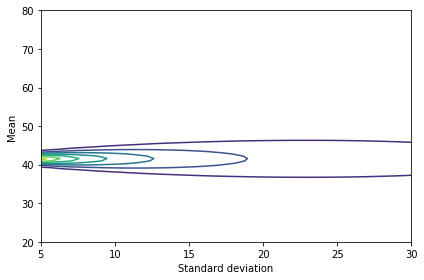

In [45]:
posterior1 = prior * like1
normalize(posterior1)
plot_contour(posterior1);

The joint posterior distribution is narrow along the vertical axis and wide along the horizontal axis, which indicates that the sample mean provides a lot of information about the population mean, but by itself it doesn't tell us much about the population standard deviation.

Let's see what happens if we update with only the standard deviation and not the mean.
Here's the likelihood:

In [46]:
like2 = chi2.pdf(n * s**2 / sigmas**2, n-1)

And here's the update:

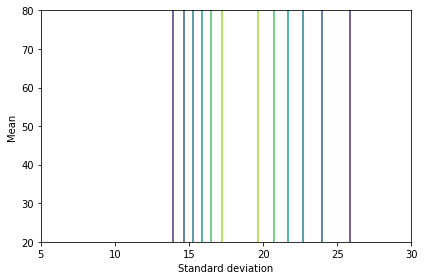

In [47]:
posterior2 = prior * like2
normalize(posterior2)
plot_contour(posterior2);

The posterior joint distribution is narrow along the horizontal axis and very wide along the vertical axis.

So the sample standard deviation provides information about the population standard deviation, but no information at all about the mean.

The following function does both updates, using the sample mean and standard deviation.

In [48]:
def update_norm_summary(prior, data):
    """
    """
    n, m, s = data
    sigmas, mus = np.meshgrid(prior.columns, prior.index)
    
    like1 = norm.pdf(m, mus, sigmas/np.sqrt(n))
    like2 = chi2.pdf(n * s**2 / sigmas**2, n-1)
    
    posterior = prior * like1 * like2
    normalize(posterior)
    
    return posterior

Here are the updates for the two groups.

In [49]:
data = summary['Control']
posterior_control = update_norm_summary(prior, data)

In [50]:
data = summary['Treated']
posterior_treated = update_norm_summary(prior, data)

And here are the results.

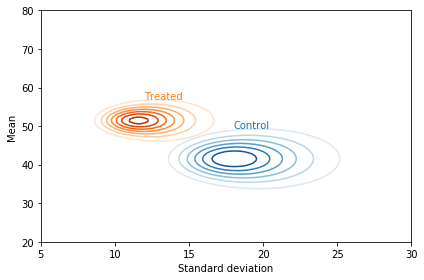

In [51]:
plot_contour(posterior_control, cmap='Blues')
plt.text(18, 49.5, 'Control', color='C0')

cs = plot_contour(posterior_treated, cmap='Oranges')
plt.text(12, 57, 'Treated', color='C1');

Visually, these posterior joint distributions are similar to the ones we computed using the entire datasets, not just the summary statistics.
But they are not exactly the same, as we can see by comparing the marginal distributions.

## Comparing marginals

In [52]:
from utils import marginal

pmf_mean_control2 = marginal(posterior_control, 1)
pmf_mean_treated2 = marginal(posterior_treated, 1)

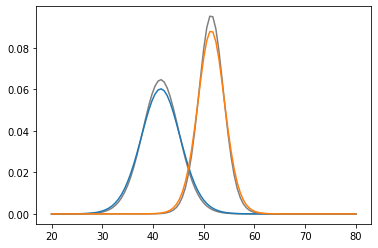

In [53]:
pmf_mean_control.plot(color='gray')
pmf_mean_control2.plot()
pmf_mean_treated.plot(color='gray')
pmf_mean_treated2.plot()

In [54]:
Pmf.prob_gt(pmf_mean_treated2, pmf_mean_control2)

0.9724264986916905

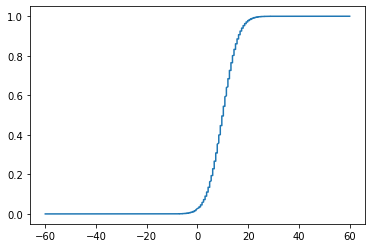

In [55]:
diff2 = Pmf.sub_dist(pmf_mean_treated2, pmf_mean_control2)
diff2.make_cdf().plot()

In [56]:
diff2.mean()

9.954349600892307

In [57]:
diff2.credible_interval(0.9)

array([ 1.8, 18. ])

## Exercises

**Exercise:** Looking again at the posterior joint distribution of `mu` and `sigma`, it seems like the standard deviation of the treated group might be lower.  Part of the reason might be a student in the control group with an unusually high score.  But another might be that the treatment is more effective for students with lower scores.

But before we speculate too much, we should estimate the size of the difference, and see whether it might actually be 0.

As we did with the values of `mu` in the previous section, extract the posterior marginal distributions of `sigma` for the two groups.
What is the probability that the standard deviation is higher in the control group?

Compute the distribution of the difference in `sigma` between the two groups.  What is the mean of this difference?  What is the 90% credible interval?

In [58]:
# Solution

pmf_std_control = marginal(posterior_control, 0)
pmf_std_treated = marginal(posterior_treated, 0)

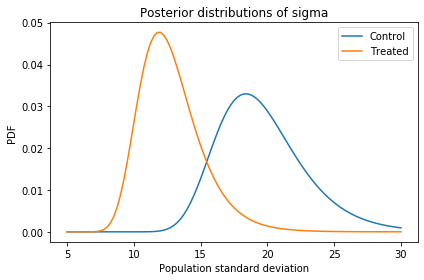

In [59]:
# Solution

pmf_std_control.plot(label='Control')
pmf_std_treated.plot(label='Treated')

decorate(xlabel='Population standard deviation', ylabel='PDF', 
         title='Posterior distributions of sigma')

In [60]:
# Solution

Pmf.prob_gt(pmf_std_control, pmf_std_treated)

0.9579193577105712

In [61]:
# Solution

diff = Pmf.sub_dist(pmf_std_control, pmf_std_treated)

In [62]:
# Solution

diff.mean()

6.735307153846935

In [63]:
# Solution

diff.credible_interval(0.9)

array([ 0.5, 13.5])

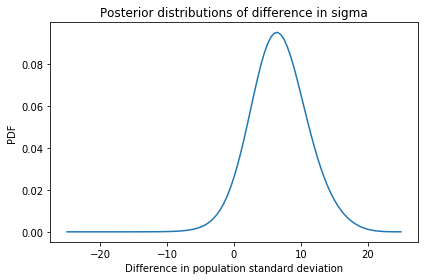

In [64]:
# Solution

make_kde(diff).plot()

decorate(xlabel='Difference in population standard deviation', 
         ylabel='PDF', 
         title='Posterior distributions of difference in sigma')

**Exercise:** This exercise is inspired by a question that appeared [on Reddit](https://www.reddit.com/r/statistics/comments/hcvl2j/q_reverse_empirical_distribution_rule_question/) .

An instructor announces the results of an exam like this, "The average score on this exam was 81.  Out of 25 students, 5 got more than 90, and I am happy to report that no one failed (got less than 60)."

Based on this information, what do you think the standard deviation of scores was?

You can assume that the distribution of scores is approximately normal.  And let's assume that the sample mean, 81, is actually the population mean, so we only have to estimate `sigma`.

Hint: To compute the probability of a score greater than 90, you can use I'm using `norm.sf`, which computes the survival function, also known as the complementary CDF, or `1 - cdf(x)`.

In [65]:
# Solution

hypos = np.linspace(1, 41, 101)

In [66]:
# Solution

from scipy.stats import norm

pgt90 = norm(81, hypos).sf(90)
pgt90.shape

(101,)

In [67]:
# Solution

from scipy.stats import binom

likelihood1 = binom(25, pgt90).pmf(5)
likelihood1.shape

(101,)

In [68]:
# Solution

prior = Pmf(1, hypos)
posterior = prior * likelihood1
posterior.normalize()

6.317005127828177

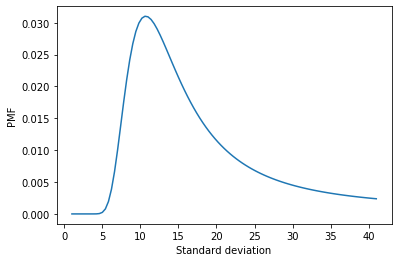

In [69]:
# Solution

posterior.plot()
plt.xlabel('Standard deviation')
plt.ylabel('PMF');

In [70]:
# Solution

pgt60s = norm(81, hypos).sf(60)

In [71]:
# Solution

likelihood2 = pgt60s ** 25

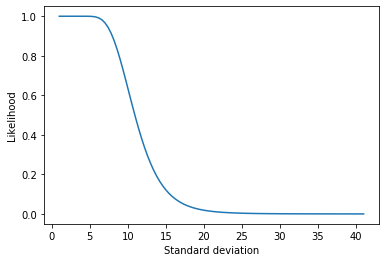

In [72]:
# Solution

plt.plot(hypos, likelihood2)
plt.xlabel('Standard deviation')
plt.ylabel('Likelihood');

In [73]:
# Solution

prior = Pmf(1, hypos)
prior.normalize()
posterior2 = prior * likelihood1 * likelihood2
posterior2.normalize()

0.017818005085371375

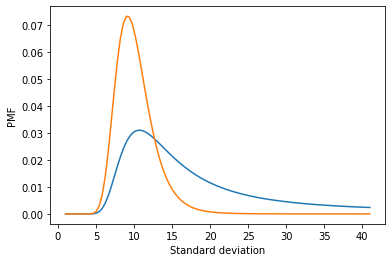

In [74]:
# Solution

posterior.plot(label='Posterior 1')
posterior2.plot(label='Posterior 2')
plt.xlabel('Standard deviation')
plt.ylabel('PMF');

In [75]:
# Solution

posterior.mean(), posterior2.mean()

(16.799831236365335, 10.189340289326903)

In [76]:
# Solution

posterior2.credible_interval(0.9)

array([ 7., 15.])

**Exercise:** I have a soft spot for crank science, so this exercise is about the [Variability Hypothesis](http://en.wikipedia.org/wiki/Variability_hypothesis), which

> "originated in the early nineteenth century with Johann Meckel, who argued that males have a greater range of ability than females, especially in intelligence. In other words, he believed that most geniuses and most mentally retarded people are men. Because he considered males to be the ’superior animal,’ Meckel concluded that females’ lack of variation was a sign of inferiority."

I particularly like that last part because I suspect that if it turned out that women were _more_ variable, Meckel would have taken that as a sign of inferiority, too. 

Nevertheless, the Variability Hypothesis suggests an exercise we can use to practice the methods in this chapter.  Let's look at the distribution of heights for men and women in the U.S. and see who is more variable.

I used 2018 data from the CDC’s [Behavioral Risk Factor Surveillance System](https://www.cdc.gov/brfss/annual_data/annual_2018.html) (BRFSS), which includes self-reported heights from 154407 men and 254722 women. 

Here’s what I found:

* The average height for men is 178 cm; the average height for women is 163 cm. So men are taller on average; no surprise there.

* For men the standard deviation is 8.27 cm; for women it is 7.75 cm. So in absolute terms, men’s heights are more variable.

But to compare variability between groups, it is more meaningful to use the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) (CV), which is the standard deviation divided by the mean. It is a dimensionless measure of variability relative to scale. 

For men CV is 0.0465; for women it is 0.0475.
The coefficient of variation is higher for women, so this dataset provides evidence against the Variability Hypothesis. But we can use Bayesian methods to make that conclusion more precise.

Use these summary statistics to compute the posterior distribution of `mu` and `sigma` for the distributions of male and female height.
Use `Pmf.div_dist` to compute posterior distributions of CV.
Based on this dataset and the assumption that the distribution of height is normal, what is the probability that the coefficient of variation is higher for men?
What is the most likely ratio of the CVs and what is the 90% credible interval for that ratio?

Hint: Use different prior distributions for the two groups, and chose them so they cover all parameters with non-negligible probability.

Also, you might find this function helpful:

In [116]:
def get_posterior_cv(joint):
    """Get the posterior distribution of CV.
    
    joint: joint distribution of mu and sigma
    
    returns: Pmf representing the smoothed posterior distribution
    """
    pmf_mean = marginal(joint, 1)
    pmf_std = marginal(joint, 0)
    pmf_cv = Pmf.div_dist(pmf_std, pmf_mean)
    return make_kde(pmf_cv)

In [77]:
# Solution

n = 154407
mean = 178
std = 8.27

In [78]:
# Solution

mus = np.linspace(mean-0.1, mean+0.1, 101)
prior_mu = Pmf(1, mus, name='mean')

sigmas = np.linspace(std-0.1, std+0.1, 101)
prior_sigma = Pmf(1, sigmas, name='std')

prior = outer_product(prior_mu, prior_sigma)

In [79]:
# Solution

data = n, mean, std
posterior_male = update_norm_summary(prior, data)
plot_contour(posterior_male, cmap='Blues');

In [81]:
# Solution

n = 254722
mean = 163
std = 7.75

In [82]:
# Solution

mus = np.linspace(mean-0.1, mean+0.1, 101)
prior_mu = Pmf(1, mus, name='mean')

sigmas = np.linspace(std-0.1, std+0.1, 101)
prior_sigma = Pmf(1, sigmas, name='std')

prior = outer_product(prior_mu, prior_sigma)

In [84]:
# Solution

data = n, mean, std
posterior_female = update_norm_summary(prior, data)
plot_contour(posterior_female, cmap='Oranges');

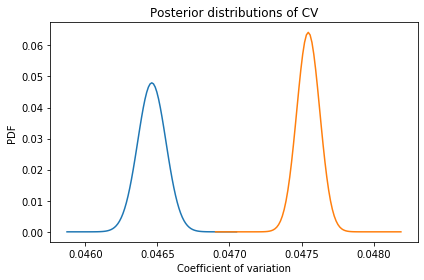

In [106]:
# Solution

pmf_cv_male = get_posterior_cv(posterior_male)
make_kde(pmf_cv_male).plot()

pmf_cv_female = get_posterior_cv(posterior_female)
make_kde(pmf_cv_female).plot()

decorate(xlabel='Coefficient of variation',
         ylabel='PDF',
         title='Posterior distributions of CV')

In [113]:
# Solution

ratio_cv = Pmf.div_dist(pmf_cv_female, pmf_cv_male)
ratio_cv.max_prob()

In [115]:
# Solution

ratio_cv.credible_interval(0.9)

array([1.0193799 , 1.02734473])